### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeSaliencyLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [11]:
batch_size = 4 #受限于贫穷，4是极限了
learning_rate = 1e-10
target_size = 256
epochs = 1

In [12]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [13]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [14]:
model = VGG16()

In [15]:
model.load_state_dict(torch.load("./model/model_29.pth"), strict=False)

<All keys matched successfully>

In [16]:
model.eval()
model.to(device)
criterion = EdgeSaliencyLoss(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [17]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.16080746054649353 Batch:100/2639 acc:0.9171820878982544 pre:0.8716006278991699 recall:0.900069534778595 F-measure:0.8758242130279541
Epoch:1 loss:0.14451877772808075 Batch:200/2639 acc:0.9165126085281372 pre:0.866449773311615 recall:0.9039759635925293 F-measure:0.8728218674659729
Epoch:1 loss:0.12502652406692505 Batch:300/2639 acc:0.915722668170929 pre:0.8654720187187195 recall:0.900395929813385 F-measure:0.8711150288581848
Epoch:1 loss:0.1385929137468338 Batch:400/2639 acc:0.9151942133903503 pre:0.8614744544029236 recall:0.8998162746429443 F-measure:0.8677086234092712
Epoch:1 loss:0.09870536625385284 Batch:500/2639 acc:0.9151354432106018 pre:0.8643280267715454 recall:0.9004011750221252 F-measure:0.8701772093772888
Epoch:1 loss:0.21886494755744934 Batch:600/2639 acc:0.9143937230110168 pre:0.8652371168136597 recall:0.8989149332046509 F-measure:0.8705135583877563
Epoch:1 loss:0.21312466263771057 Batch:700/2639 acc:0.9145800471305847 pre:0.8648743629455566 recall:0.89920341

In [18]:
torch.save(model.state_dict(),"./model/model_30.pth")

In [19]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [20]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [21]:
img = getInput("./image/1.jpg")

In [22]:
img.shape

torch.Size([3, 256, 256])

In [23]:
img = img.reshape(1, 3, 256, 256)
img = img.to(device)

In [24]:
predict = model(img)

In [25]:
predict.shape

torch.Size([1, 1, 256, 256])

In [26]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [27]:
msk.shape

torch.Size([256, 256, 1])

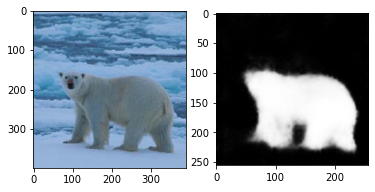

In [30]:
msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk*255, cmap='gray')
plt.show()

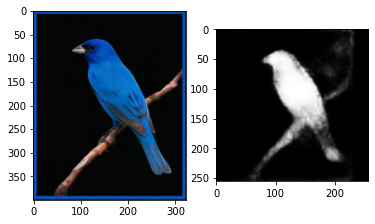

In [33]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk*255, cmap='gray')
plt.show()

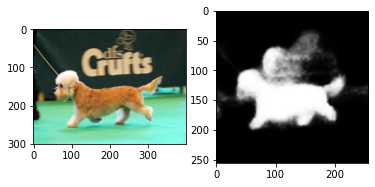

In [40]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk*255, cmap='gray')
plt.show()

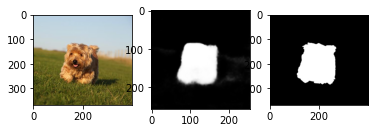

In [41]:
img = getInput("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk*255, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png"))
plt.show()